In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from random import shuffle

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [2]:
tsla_data = pd.read_csv('./TSLA.csv')
goog_data = pd.read_csv('./GOOGL.csv')
dji_data = pd.read_csv('./DJI.csv')

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [3]:
scaler = MinMaxScaler()
tsla_open = scaler.fit_transform(tsla_data.iloc[:,1:])[:,0]
goog_open = scaler.fit_transform(goog_data.iloc[:, 1:])[:,0]
dji_open = scaler.fit_transform(dji_data.iloc[:,1:])[:,0]

/usr/lusers/dcashon/.conda/envs/neural_nets/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/lusers/dcashon/.conda/envs/neural_nets/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/lusers/dcashon/.conda/envs/neural_nets/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(8636,)
(2227,)
(3702,)


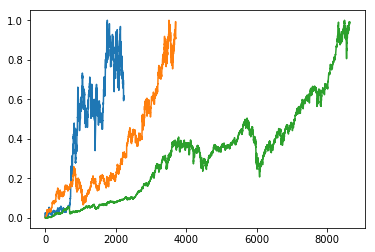

In [4]:
# quick viz
plt.plot(tsla_open)
plt.plot(goog_open)
plt.plot(dji_open)
print(dji_open.shape)
print(tsla_open.shape)
print(goog_open.shape)


# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [100]:
def split(data, size):
    """
    If data is a list, will split all (e.g. we use all the tsla, goog, dji data)
    Parameters:
        -data: 1D numpy array of opening price
        -size: how many days back to use
    Outputs:
        -
    """
    if isinstance(data, list):
        print('Data is in list, concatenating...')
        l_data = []
        for d in data:
            for i in range(size, len(data)):
                l_data.append(d[i-size:i+1])
    else:
        l_data = []
        for i in range(size, len(data)):
            l_data.append(data[i-size:i+1])
    np_data = np.vstack(l_data)
    data, labels = np_data[:,:-1], np_data[:,-1]
    x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)
    return x_train, y_train, x_val, y_val, x_test, y_test

def minibatch(data, labels, batch_size):
    start, end = 0, batch_size
    while end < len(data):
        yield data[start:end], labels[start:end]
        start += batch_size
        end += batch_size
        
        

In [109]:
# get all the data ready
num_days = 25 # number of days to predict back with
x_tsla_train, y_tsla_train, x_tsla_val, y_tsla_val, x_tsla_test, y_tsla_test = split(tsla_open, num_days)
x_goog_train, y_goog_train, x_goog_val, y_goog_val, x_goog_test, y_goog_test = split(goog_open, num_days)
x_dji_train, y_dji_train, x_dji_val, y_dji_val, x_dji_test, y_dji_test = split(dji_open, num_days)

# TensorFlow Model
## Different model trained for each stock (3 total models)

In [112]:
# hyperparameters
num_epochs = 25 # found to be sufficient before val loss increase
batch_size = 128
lr = 0.001

# model parameters
tf.reset_default_graph()
num_steps = num_days # number of days to use to predict
num_inputs = 1 # scalar input (open price)
num_neurons = 128 # recurrent neurons per cell
num_outputs = 1

# construct the graph
tf.reset_default_graph()

# placeholders for input stock data open prices
X = tf.placeholder(tf.float32, shape=[None, num_steps, num_inputs])
Y = tf.placeholder(tf.float32, shape=[None])

# RNN
cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) #unwrap

# fully connected layer at end-state to get scalar prediction of next stock value
pred = tf.layers.dense(states[-1], num_outputs) # have to index into state to get hidden state for prediction use

# loss
loss = tf.reduce_mean(tf.square(pred - Y))
opt = tf.train.AdamOptimizer(learning_rate=lr)
minimize = opt.minimize(loss)


# Training - TSLA Model

In [116]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        print('Training on Epoch: \t' + str(epoch))
        batcher = minibatch(x_tsla_train, y_tsla_train, batch_size)
        for data, labels in batcher:
            f_dict = {X: np.reshape(data, (-1, num_days, 1)), Y:labels}
            sess.run(minimize, feed_dict=f_dict)
            if epoch == 0:
                print(sess.run(loss, feed_dict=f_dict))
        if epoch % 5 == 0:
            print('Train Batch Loss: ')
            print(sess.run(loss, feed_dict=f_dict))
            print('Val Loss')
            print(sess.run(loss, feed_dict={X:np.reshape(x_tsla_val,(-1, num_days,1)), Y:y_val}))
    print("Test Loss")
    print(sess.run(loss, feed_dict={X:np.reshape(x_tsla_test, (-1,num_days,1)), Y:y_tsla_test}))
    to_test = sess.run(pred, feed_dict={X:np.reshape(x_tsla_test, (-1,num_days,1)), Y:y_tsla_test})

Training on Epoch: 	0
0.22483853
0.21378729
0.15582961
0.14104043
0.14367582
0.15677765
0.14564702
0.1353479
0.1197232
0.10848897
0.13415773
0.13491398
0.12150433
Train Batch Loss: 
0.12150433
Val Loss
0.12096821
Training on Epoch: 	1
Training on Epoch: 	2
Training on Epoch: 	3
Training on Epoch: 	4
Training on Epoch: 	5
Train Batch Loss: 
0.09996931
Val Loss
0.0921178
Training on Epoch: 	6
Training on Epoch: 	7
Training on Epoch: 	8
Training on Epoch: 	9
Training on Epoch: 	10
Train Batch Loss: 
0.10033425
Val Loss
0.09206222
Training on Epoch: 	11
Training on Epoch: 	12
Training on Epoch: 	13
Training on Epoch: 	14
Training on Epoch: 	15
Train Batch Loss: 
0.10029617
Val Loss
0.09206456
Training on Epoch: 	16
Training on Epoch: 	17
Training on Epoch: 	18
Training on Epoch: 	19
Training on Epoch: 	20
Train Batch Loss: 
0.10030939
Val Loss
0.09206439
Training on Epoch: 	21
Training on Epoch: 	22
Training on Epoch: 	23
Training on Epoch: 	24
Test Loss
0.09781251


# Testing

In [117]:
# plot error for 100 days of tesla predictions
tsla_error = np.squeeze(to_test) - y_test

(-1, 1)

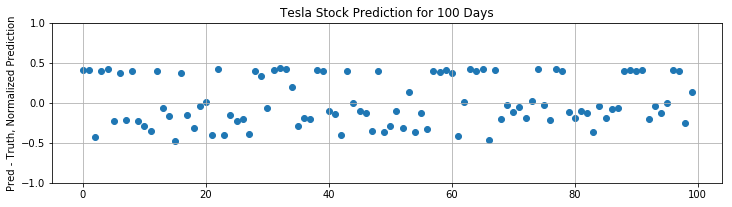

In [118]:
plt.figure(1, figsize=(12,10))
plt.subplot(311)
plt.scatter(np.arange(100),tsla_error[:100])
plt.grid(True)
plt.ylabel('Pred - Truth, Normalized Prediction')
plt.title('Tesla Stock Prediction for 100 Days')
plt.ylim(-1,1)

# Training - GOOG Model (same as TSLA)

In [119]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        print('Training on Epoch: \t' + str(epoch))
        batcher = minibatch(x_goog_train, y_goog_train, batch_size)
        for data, labels in batcher:
            f_dict = {X: np.reshape(data, (-1, num_days, 1)), Y:labels}
            sess.run(minimize, feed_dict=f_dict)
            if epoch == 0:
                print(sess.run(loss, feed_dict=f_dict))
        if epoch % 5 == 0:
            print('Train Batch Loss: ')
            print(sess.run(loss, feed_dict=f_dict))
            print('Val Loss')
            print(sess.run(loss, feed_dict={X:np.reshape(x_goog_val,(-1, num_days,1)), Y:y_goog_val}))
    print("Test Loss")
    print(sess.run(loss, feed_dict={X:np.reshape(x_goog_test, (-1,num_days,1)), Y:y_goog_test}))
    to_test = sess.run(pred, feed_dict={X:np.reshape(x_goog_test, (-1,num_days,1)), Y:y_goog_test})

Training on Epoch: 	0
0.1241747
0.083963394
0.101282924
0.114170395
0.09385728
0.07657398
0.100006066
0.06693831
0.07781768
0.094553985
0.0763934
0.07361987
0.0736037
0.0688415
0.072611704
0.06882022
0.06879629
0.0841334
0.045367457
0.0497702
0.06066726
0.060777143
Train Batch Loss: 
0.060777143
Val Loss
0.067140914
Training on Epoch: 	1
Training on Epoch: 	2
Training on Epoch: 	3
Training on Epoch: 	4
Training on Epoch: 	5
Train Batch Loss: 
0.05986226
Val Loss
0.06654154
Training on Epoch: 	6
Training on Epoch: 	7
Training on Epoch: 	8
Training on Epoch: 	9
Training on Epoch: 	10
Train Batch Loss: 
0.059856247
Val Loss
0.0665095
Training on Epoch: 	11
Training on Epoch: 	12
Training on Epoch: 	13
Training on Epoch: 	14
Training on Epoch: 	15
Train Batch Loss: 
0.05985206
Val Loss
0.066478215
Training on Epoch: 	16
Training on Epoch: 	17
Training on Epoch: 	18
Training on Epoch: 	19
Training on Epoch: 	20
Train Batch Loss: 
0.059850138
Val Loss
0.06645762
Training on Epoch: 	21
Traini

# Test - Result GOOG Model

(-1, 1)

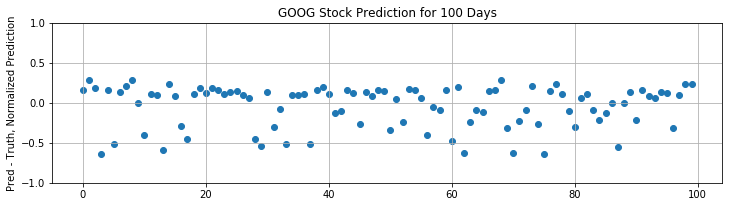

In [121]:
goog_error = np.squeeze(to_test) - y_goog_test
plt.figure(2, figsize=(12,10))
plt.subplot(311)
plt.scatter(np.arange(100),goog_error[:100])
plt.grid(True)
plt.ylabel('Pred - Truth, Normalized Prediction')
plt.title('GOOG Stock Prediction for 100 Days')
plt.ylim(-1,1)

# Training - DJI Model (same)

In [123]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        print('Training on Epoch: \t' + str(epoch))
        batcher = minibatch(x_dji_train, y_dji_train, batch_size)
        for data, labels in batcher:
            f_dict = {X: np.reshape(data, (-1, num_days, 1)), Y:labels}
            sess.run(minimize, feed_dict=f_dict)
            if epoch == 0:
                print(sess.run(loss, feed_dict=f_dict))
        if epoch % 5 == 0:
            print('Train Batch Loss: ')
            print(sess.run(loss, feed_dict=f_dict))
            print('Val Loss')
            print(sess.run(loss, feed_dict={X:np.reshape(x_dji_val,(-1, num_days,1)), Y:y_dji_val}))
    print("Test Loss")
    print(sess.run(loss, feed_dict={X:np.reshape(x_dji_test, (-1,num_days,1)), Y:y_dji_test}))
    to_test = sess.run(pred, feed_dict={X:np.reshape(x_dji_test, (-1,num_days,1)), Y:y_dji_test})

Training on Epoch: 	0
0.14624174
0.12858514
0.10336575
0.08384827
0.09316382
0.09614943
0.08651568
0.0832769
0.06393331
0.06754327
0.07885602
0.063172236
0.05568865
0.06926267
0.062135063
0.045616426
0.07158909
0.06139902
0.052418735
0.06250182
0.06300313
0.06837976
0.059546817
0.06892114
0.0546778
0.07494967
0.062090017
0.05307536
0.05471333
0.050857373
0.05314995
0.0717292
0.065445706
0.06419829
0.08369489
0.07438358
0.06308775
0.058043703
0.071130194
0.054381408
0.05403556
0.069683135
0.053404942
0.06392496
0.05604473
0.048932485
0.052162774
0.052457847
0.059413936
0.053559028
0.05414702
0.04138368
0.050097577
Train Batch Loss: 
0.050097577
Val Loss
0.05491213
Training on Epoch: 	1
Training on Epoch: 	2
Training on Epoch: 	3
Training on Epoch: 	4
Training on Epoch: 	5
Train Batch Loss: 
0.04982573
Val Loss
0.053866014
Training on Epoch: 	6
Training on Epoch: 	7
Training on Epoch: 	8
Training on Epoch: 	9
Training on Epoch: 	10
Train Batch Loss: 
0.049849495
Val Loss
0.05358632
Train

# Test - Result DJI Model

(-1, 1)

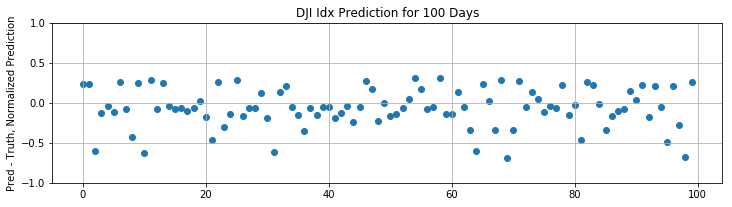

In [124]:
dji_error = np.squeeze(to_test) - y_dji_test
plt.figure(2, figsize=(12,10))
plt.subplot(311)
plt.scatter(np.arange(100),dji_error[:100])
plt.grid(True)
plt.ylabel('Pred - Truth, Normalized Prediction')
plt.title('DJI Idx Prediction for 100 Days')
plt.ylim(-1,1)